# Matrics

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import directed_hausdorff

""" Loss Functions -------------------------------------- """
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

""" Metrics ------------------------------------------ """
def precision(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    return (intersection + 1e-15) / (y_pred.sum() + 1e-15)

def recall(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    return (intersection + 1e-15) / (y_true.sum() + 1e-15)

def F2(y_true, y_pred, beta=2):
    p = precision(y_true,y_pred)
    r = recall(y_true, y_pred)
    return (1+beta**2.) *(p*r) / float(beta**2*p + r + 1e-15)

def dice_score(y_true, y_pred):
    return (2 * (y_true * y_pred).sum() + 1e-15) / (y_true.sum() + y_pred.sum() + 1e-15)

def jac_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-15) / (union + 1e-15)

## https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/319452
def hd_dist(preds, targets):
    haussdorf_dist = directed_hausdorff(preds, targets)[0]
    return haussdorf_dist

# Utils

In [2]:
import os
import random
import numpy as np
import cv2
from tqdm import tqdm
import torch
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Shuffle the dataset. """
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def print_and_save(file_path, data_str):
    print(data_str)
    with open(file_path, "a") as file:
        file.write(data_str)
        file.write("\n")

def calculate_metrics(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    y_pred = y_pred > 0.5
    y_pred = y_pred.reshape(-1)
    y_pred = y_pred.astype(np.uint8)

    y_true = y_true > 0.5
    y_true = y_true.reshape(-1)
    y_true = y_true.astype(np.uint8)

    ## Score
    score_jaccard = jac_score(y_true, y_pred)
    score_f1 = dice_score(y_true, y_pred)
    score_recall = recall(y_true, y_pred)
    score_precision = precision(y_true, y_pred)
    score_fbeta = F2(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc, score_fbeta]

# Resnet

In [3]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=True, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

# Model

In [4]:

import torch
import torch.nn as nn

class Conv2D(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1, stride=1, dilation=1, bias=True, act=True):
        super().__init__()

        self.act = act
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size, padding=padding, dilation=dilation, stride=stride, bias=bias),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.act == True:
            x = self.relu(x)
        return x

class residual_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c)
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, inputs):
        x = self.conv(inputs)
        s = self.shortcut(inputs)
        return self.relu(x + s)

class residual_transformer_block(nn.Module):
    def __init__(self, in_c, out_c, patch_size=4, num_heads=4, num_layers=2, dim=None):
        super().__init__()

        self.ps = patch_size
        self.c1 = Conv2D(in_c, out_c)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads)
        self.te = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.c2 = Conv2D(out_c, out_c, kernel_size=1, padding=0, act=False)
        self.c3 = Conv2D(in_c, out_c, kernel_size=1, padding=0, act=False)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.r1 = residual_block(out_c, out_c)

    def forward(self, inputs):
        x = self.c1(inputs)

        b, c, h, w = x.shape
        num_patches = (h*w)//(self.ps**2)
        x = torch.reshape(x, (b, (self.ps**2)*c, num_patches))
        x = self.te(x)
        x = torch.reshape(x, (b, c, h, w))

        x = self.c2(x)
        s = self.c3(inputs)
        x = self.relu(x + s)
        x = self.r1(x)
        return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        backbone = resnet50()
        self.layer0 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)
        self.layer1 = nn.Sequential(backbone.maxpool, backbone.layer1)
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        self.e1 = Conv2D(64, 64, kernel_size=1, padding=0)
        self.e2 = Conv2D(256, 64, kernel_size=1, padding=0)
        self.e3 = Conv2D(512, 64, kernel_size=1, padding=0)
        self.e4 = Conv2D(1024, 64, kernel_size=1, padding=0)


        """ Decoder """
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.r1 = residual_transformer_block(64+64, 64, dim=64)
        self.r2 = residual_transformer_block(64+64, 64, dim=256)
        self.r3 = residual_block(64+64, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        x0 = inputs
        x1 = self.layer0(x0)    ## [-1, 64, h/2, w/2]
        x2 = self.layer1(x1)    ## [-1, 256, h/4, w/4]
        x3 = self.layer2(x2)    ## [-1, 512, h/8, w/8]
        x4 = self.layer3(x3)    ## [-1, 1024, h/16, w/16]
        # print(x1.shape, x2.shape, x3.shape, x4.shape)

        e1 = self.e1(x1)
        e2 = self.e2(x2)
        e3 = self.e3(x3)
        e4 = self.e4(x4)

        """ Decoder """
        x = self.up(e4)
        x = torch.cat([x, e3], axis=1)
        x = self.r1(x)

        x = self.up(x)
        x = torch.cat([x, e2], axis=1)
        x = self.r2(x)

        x = self.up(x)
        x = torch.cat([x, e1], axis=1)
        x = self.r3(x)

        x = self.up(x)

        """ Classifier """
        outputs = self.outputs(x)
        return outputs

# Train Utils

In [5]:
import os
import random
import time
import datetime
import numpy as np
import albumentations as A
import cv2
from PIL import Image
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

def load_names(path, image_name, mask_name):
    image_paths = []
    for root, dirs, files in os.walk(os.path.join(path, image_name)):
        for file in files:
            if file.endswith(('.png')):
                full_path = os.path.join(root, file)
                image_paths.append(full_path)
    
    mask_paths = []
    for root, dirs, files in os.walk(os.path.join(path, mask_name)):
        for file in files:
            if file.endswith(('.png')):
                full_path = os.path.join(root, file)
                mask_paths.append(full_path)
                
    return image_paths, mask_paths

def load_data(path):
    path += "/PNG"

    train_x, train_y = load_names(path, "Original", "Ground Truth")
    
    num_examples = len(train_x)
    test_size = int(num_examples * 0.2)
    temp_x, test_x, temp_y, test_y = train_test_split(train_x, train_y, test_size=test_size, random_state=42)
    train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

class DATASET(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        super().__init__()
        
        new_images_path = []
        for path in images_path:
            if not os.path.exists(path):
                print(path)
                continue
            new_images_path.append(path)
            
        new_masks_path = []
        for path in masks_path:
            if not os.path.exists(path):
                continue
            new_masks_path.append(path)

        self.images_path = new_images_path
        self.masks_path = new_masks_path
        self.transform = transform
        self.n_samples = len(new_images_path)

    def __getitem__(self, index):
        """ Image """
        
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            if not isinstance(image, np.ndarray):
                image = np.array(image)
            if not isinstance(mask, np.ndarray):
                mask = np.array(mask)
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        image = cv2.resize(image, size)
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0

        mask = cv2.resize(mask, size)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        
        image = np.array(image)
        mask = np.array(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

def train(model, loader, optimizer, loss_fn, device):
    model.train()

    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    for i, (x, y) in enumerate(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        """ Calculate the metrics """
        batch_jac = []
        batch_f1 = []
        batch_recall = []
        batch_precision = []

        for yt, yp in zip(y, y_pred):
            score = calculate_metrics(yt, yp)
            batch_jac.append(score[0])
            batch_f1.append(score[1])
            batch_recall.append(score[2])
            batch_precision.append(score[3])

        epoch_jac += np.mean(batch_jac)
        epoch_f1 += np.mean(batch_f1)
        epoch_recall += np.mean(batch_recall)
        epoch_precision += np.mean(batch_precision)

    epoch_loss = epoch_loss/len(loader)
    epoch_jac = epoch_jac/len(loader)
    epoch_f1 = epoch_f1/len(loader)
    epoch_recall = epoch_recall/len(loader)
    epoch_precision = epoch_precision/len(loader)

    return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

def evaluate(model, loader, loss_fn, device):
    model.eval()

    epoch_loss = 0
    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            """ Calculate the metrics """
            batch_jac = []
            batch_f1 = []
            batch_recall = []
            batch_precision = []

            for yt, yp in zip(y, y_pred):
                score = calculate_metrics(yt, yp)
                batch_jac.append(score[0])
                batch_f1.append(score[1])
                batch_recall.append(score[2])
                batch_precision.append(score[3])

            epoch_jac += np.mean(batch_jac)
            epoch_f1 += np.mean(batch_f1)
            epoch_recall += np.mean(batch_recall)
            epoch_precision += np.mean(batch_precision)

        epoch_loss = epoch_loss/len(loader)
        epoch_jac = epoch_jac/len(loader)
        epoch_f1 = epoch_f1/len(loader)
        epoch_recall = epoch_recall/len(loader)
        epoch_precision = epoch_precision/len(loader)

        return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

# Test Utils

In [6]:
import os, time
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch

def calculate_hd(y_true, y_pred):
    y_true = y_true[0][0].detach().cpu().numpy()
    y_pred = y_pred[0][0].detach().cpu().numpy()

    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)

    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)

    return hd_dist(y_true, y_pred)


def evaluate_test(model, save_path, test_x, test_y, size):
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        name = y.split("/")[-1].split(".")[0]

        """ Image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, size)
        save_img = image
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        image = image.to(device)

        """ Mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, size)
        save_mask = mask
        save_mask = np.expand_dims(save_mask, axis=-1)
        save_mask = np.concatenate([save_mask, save_mask, save_mask], axis=2)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        mask = mask.to(device)

        with torch.no_grad():
            """ FPS calculation """
            start_time = time.time()
            y_pred = model(image)
            y_pred = torch.sigmoid(y_pred)
            end_time = time.time() - start_time
            time_taken.append(end_time)

            """ Evaluation metrics """
            score = calculate_metrics(mask, y_pred)
            hd = calculate_hd(mask, y_pred)
            score.append(hd)
            metrics_score = list(map(add, metrics_score, score))

            """ Predicted Mask """
            y_pred = y_pred[0].cpu().numpy()
            y_pred = np.squeeze(y_pred, axis=0)
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = y_pred * 255
            y_pred = np.array(y_pred, dtype=np.uint8)
            y_pred = np.expand_dims(y_pred, axis=-1)
            y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=2)

        """ Save the image - mask - pred """
        line = np.ones((size[0], 10, 3)) * 255
        cat_images = np.concatenate([save_img, line, save_mask, line, y_pred], axis=1)
        cv2.imwrite(f"{save_path}/joint/{name}.jpg", cat_images)
        cv2.imwrite(f"{save_path}/mask/{name}.jpg", y_pred)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    f2 = metrics_score[5]/len(test_x)
    hd = metrics_score[6]/len(test_x)

    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f} - F2: {f2:1.4f} - HD: {hd:2.4f}")

    mean_time_taken = np.mean(time_taken)
    mean_fps = 1/mean_time_taken
    print("Mean FPS: ", mean_fps)

# Main CVC-ClinicDB

In [7]:
x = torch.randn((4, 3, 256, 256))
model = Model()
y = model(x)
print(y.shape)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([4, 1, 256, 256])


In [8]:
""" Seeding """
seeding(42)

""" Directories """
create_dir("files")

""" Training logfile """
train_log_path = "/kaggle/working/train_log.txt"
if os.path.exists(train_log_path):
    print("Log file exists")
else:
    train_log = open("/kaggle/working/train_log.txt", "w")
    train_log.write("\n")
    train_log.close()

""" Record Date & Time """
datetime_object = str(datetime.datetime.now())
print_and_save(train_log_path, datetime_object)
print("")

""" Hyperparameters """
image_size = 256
size = (image_size, image_size)
batch_size = 16
num_epochs = 100
lr = 1e-4
early_stopping_patience = 50
checkpoint_path = "/kaggle/working/checkpoint.pth"
path = "/kaggle/input/cvcclinicdb"


data_str = f"Image Size: {size}\nBatch Size: {batch_size}\nLR: {lr}\nEpochs: {num_epochs}\n"
data_str += f"Early Stopping Patience: {early_stopping_patience}\n"
print_and_save(train_log_path, data_str)

""" Dataset """
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
train_x, train_y = shuffling(train_x, train_y)
data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print_and_save(train_log_path, data_str)

""" Data augmentation: Transforms """
transform =  A.Compose([
    A.Rotate(limit=35, p=0.3),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.CoarseDropout(p=0.3, max_holes=10, max_height=32, max_width=32)
])

""" Dataset and loader """
train_dataset = DATASET(train_x, train_y, size, transform=transform)
valid_dataset = DATASET(valid_x, valid_y, size, transform=None)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

""" Model """
device = torch.device('cuda')
model = Model()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()
loss_name = "BCE Dice Loss"
data_str = f"Optimizer: Adam\nLoss: {loss_name}\n"
print_and_save(train_log_path, data_str)

""" Training the model """
best_valid_metrics = 0.0
early_stopping_count = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_metrics = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss, valid_metrics = evaluate(model, valid_loader, loss_fn, device)
    scheduler.step(valid_loss)

    if valid_metrics[1] > best_valid_metrics:
        data_str = f"Valid F1 improved from {best_valid_metrics:2.4f} to {valid_metrics[1]:2.4f}. Saving checkpoint: {checkpoint_path}"
        print_and_save(train_log_path, data_str)

        best_valid_metrics = valid_metrics[1]
        torch.save(model.state_dict(), checkpoint_path)
        early_stopping_count = 0

    elif valid_metrics[1] < best_valid_metrics:
        early_stopping_count += 1

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n"
    data_str += f"\tTrain Loss: {train_loss:.4f} - Jaccard: {train_metrics[0]:.4f} - F1: {train_metrics[1]:.4f} - Recall: {train_metrics[2]:.4f} - Precision: {train_metrics[3]:.4f}\n"
    train_losses.append([train_loss, train_metrics[0], train_metrics[1], train_metrics[2], train_metrics[3]])
    data_str += f"\t Val. Loss: {valid_loss:.4f} - Jaccard: {valid_metrics[0]:.4f} - F1: {valid_metrics[1]:.4f} - Recall: {valid_metrics[2]:.4f} - Precision: {valid_metrics[3]:.4f}\n"
    val_losses.append([valid_loss, valid_metrics[0], valid_metrics[1], valid_metrics[2], valid_metrics[3]])
    print_and_save(train_log_path, data_str)

    if early_stopping_count == early_stopping_patience:
        data_str = f"Early stopping: validation loss stops improving from last {early_stopping_patience} continously.\n"
        print_and_save(train_log_path, data_str)
        break

2024-07-11 15:47:40.899593

Image Size: (256, 256)
Batch Size: 16
LR: 0.0001
Epochs: 100
Early Stopping Patience: 50

Dataset Size:
Train: 368 - Valid: 122

Optimizer: Adam
Loss: BCE Dice Loss

Valid F1 improved from 0.0000 to 0.4898. Saving checkpoint: /kaggle/working/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 1.2017 - Jaccard: 0.3836 - F1: 0.5126 - Recall: 0.7344 - Precision: 0.4546
	 Val. Loss: 1.1643 - Jaccard: 0.3803 - F1: 0.4898 - Recall: 0.3923 - Precision: 0.9548

Valid F1 improved from 0.4898 to 0.7797. Saving checkpoint: /kaggle/working/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.8344 - Jaccard: 0.6128 - F1: 0.7317 - Recall: 0.8096 - Precision: 0.7505
	 Val. Loss: 0.7589 - Jaccard: 0.6814 - F1: 0.7797 - Recall: 0.7543 - Precision: 0.9040

Valid F1 improved from 0.7797 to 0.8321. Saving checkpoint: /kaggle/working/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.7149 - Jaccard: 0.6788 - F1: 0.7846 - Recall: 0.8342 - Precision: 0.808

In [9]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

""" Test dataset """
path = "/kaggle/input/cvcclinicdb"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

save_path = f"/kaggle/working/results/CVC-ClinicDB"
for item in ["mask", "joint"]:
    create_dir(f"{save_path}/{item}")

size = (256, 256)
create_dir(save_path)
evaluate_test(model, save_path, test_x, test_y, size)

100%|██████████| 122/122 [00:05<00:00, 21.68it/s]

Jaccard: 0.8534 - F1: 0.9079 - Recall: 0.9077 - Precision: 0.9297 - Acc: 0.9881 - F2: 0.9069 - HD: 3.2200
Mean FPS:  80.88709162660159


Text(0.5, 1.0, 'Train Loss')

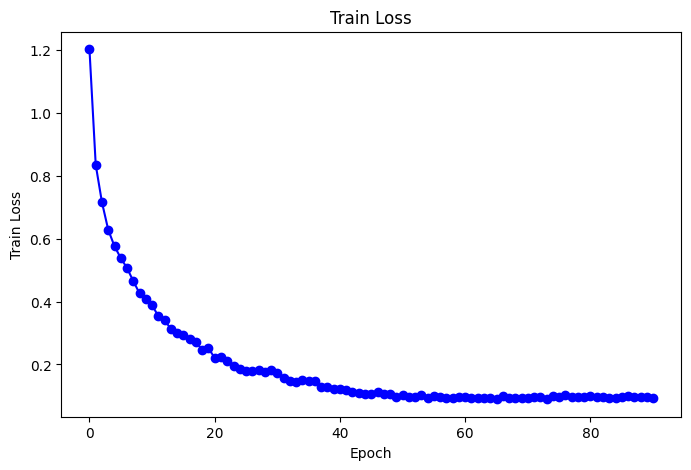

In [12]:
import matplotlib.pyplot as plt

train_loss = [a[0] for a in train_losses]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, marker='o', linestyle='-', color='b', label='Train loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Jaccard')

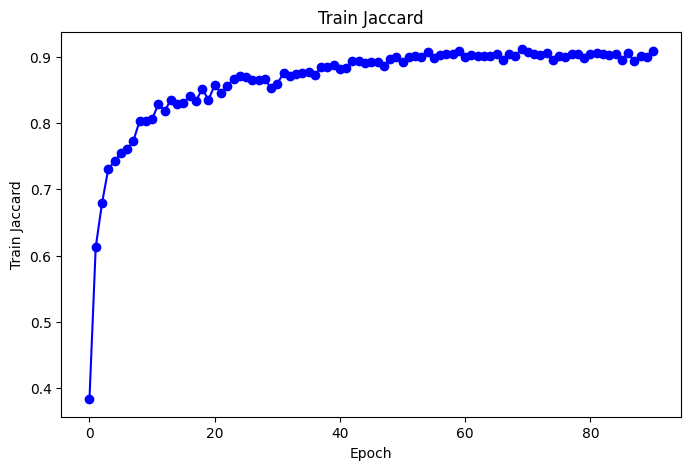

In [14]:
import matplotlib.pyplot as plt

train_Jaccard = [a[1] for a in train_losses]

plt.figure(figsize=(8, 5))
plt.plot(train_Jaccard, marker='o', linestyle='-', color='b', label='Train Jaccard')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Train Jaccard')
plt.title('Train Jaccard')

Text(0.5, 1.0, 'Train F1')

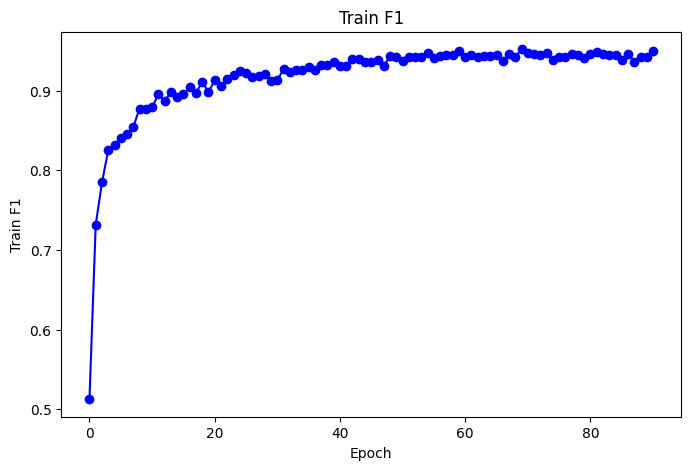

In [15]:
import matplotlib.pyplot as plt

train_F1 = [a[2] for a in train_losses]

plt.figure(figsize=(8, 5))
plt.plot(train_F1, marker='o', linestyle='-', color='b', label='Train F1')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Train F1')
plt.title('Train F1')

Text(0.5, 1.0, 'Train Recall')

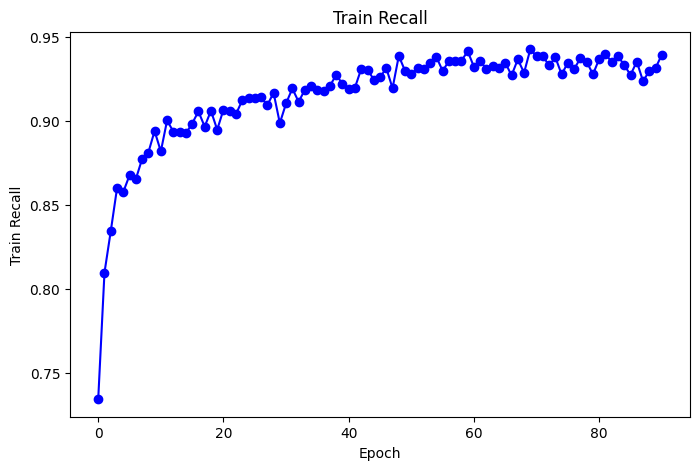

In [16]:
import matplotlib.pyplot as plt

train_Recall = [a[3] for a in train_losses]

plt.figure(figsize=(8, 5))
plt.plot(train_Recall, marker='o', linestyle='-', color='b', label='Train Recall')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Train Recall')
plt.title('Train Recall')

# Train Utils for Retinal Blood Vessel

In [19]:
def load_names2(path, image_name, mask_name):
    image_paths = []
    for root, dirs, files in os.walk(os.path.join(path, image_name)):
        for file in files:
            if file.endswith(('.png')):
                full_path = os.path.join(root, file)
                image_paths.append(full_path)
    
    mask_paths = []
    for root, dirs, files in os.walk(os.path.join(path, mask_name)):
        for file in files:
            if file.endswith(('.png')):
                full_path = os.path.join(root, file)
                mask_paths.append(full_path)
                
    return image_paths, mask_paths

def load_data2(path):
    path += "/Data"

    train_x, train_y = load_names2(path + "/train", "image", "mask")
    
    num_examples = len(train_x)
    valid_size = int(num_examples * 0.2)
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=valid_size, random_state=42)
    
    test_x, test_y = load_names(path + "/test", "image", "mask")

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


# Main Retinal Blood Vessel

In [23]:
x = torch.randn((4, 3, 256, 256))
model = Model()
y = model(x)
print(y.shape)

torch.Size([4, 1, 256, 256])


In [24]:
""" Seeding """
seeding(42)

""" Directories """
create_dir("files")

""" Training logfile """
train_log_path = "/kaggle/working/train_log.txt"
if os.path.exists(train_log_path):
    print("Log file exists")
else:
    train_log = open("/kaggle/working/train_log.txt", "w")
    train_log.write("\n")
    train_log.close()

""" Record Date & Time """
datetime_object = str(datetime.datetime.now())
print_and_save(train_log_path, datetime_object)
print("")

""" Hyperparameters """
image_size = 256
size = (image_size, image_size)
batch_size = 8
num_epochs = 500
lr = 1e-4
early_stopping_patience = 50
checkpoint_path = "/kaggle/working/checkpoint.pth"
path = "/kaggle/input/retina-blood-vessel"


data_str = f"Image Size: {size}\nBatch Size: {batch_size}\nLR: {lr}\nEpochs: {num_epochs}\n"
data_str += f"Early Stopping Patience: {early_stopping_patience}\n"
print_and_save(train_log_path, data_str)

""" Dataset """
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data2(path)
train_x, train_y = shuffling(train_x, train_y)
data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print_and_save(train_log_path, data_str)

""" Data augmentation: Transforms """
transform =  A.Compose([
    A.Rotate(limit=35, p=0.3),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.CoarseDropout(p=0.3, max_holes=10, max_height=32, max_width=32)
])

""" Dataset and loader """
train_dataset = DATASET(train_x, train_y, size, transform=transform)
valid_dataset = DATASET(valid_x, valid_y, size, transform=None)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

""" Model """
device = torch.device('cuda')
model = Model()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()
loss_name = "BCE Dice Loss"
data_str = f"Optimizer: Adam\nLoss: {loss_name}\n"
print_and_save(train_log_path, data_str)

""" Training the model """
best_valid_metrics = 0.0
early_stopping_count = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_metrics = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss, valid_metrics = evaluate(model, valid_loader, loss_fn, device)
    scheduler.step(valid_loss)

    if valid_metrics[1] > best_valid_metrics:
        data_str = f"Valid F1 improved from {best_valid_metrics:2.4f} to {valid_metrics[1]:2.4f}. Saving checkpoint: {checkpoint_path}"
        print_and_save(train_log_path, data_str)

        best_valid_metrics = valid_metrics[1]
        torch.save(model.state_dict(), checkpoint_path)
        early_stopping_count = 0

    elif valid_metrics[1] < best_valid_metrics:
        early_stopping_count += 1

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n"
    data_str += f"\tTrain Loss: {train_loss:.4f} - Jaccard: {train_metrics[0]:.4f} - F1: {train_metrics[1]:.4f} - Recall: {train_metrics[2]:.4f} - Precision: {train_metrics[3]:.4f}\n"
    train_losses.append([train_loss, train_metrics[0], train_metrics[1], train_metrics[2], train_metrics[3]])
    data_str += f"\t Val. Loss: {valid_loss:.4f} - Jaccard: {valid_metrics[0]:.4f} - F1: {valid_metrics[1]:.4f} - Recall: {valid_metrics[2]:.4f} - Precision: {valid_metrics[3]:.4f}\n"
    val_losses.append([valid_loss, valid_metrics[0], valid_metrics[1], valid_metrics[2], valid_metrics[3]])
    print_and_save(train_log_path, data_str)

    if early_stopping_count == early_stopping_patience:
        data_str = f"Early stopping: validation loss stops improving from last {early_stopping_patience} continously.\n"
        print_and_save(train_log_path, data_str)
        break

Log file exists
2024-07-11 16:36:52.458867

Image Size: (256, 256)
Batch Size: 8
LR: 0.0001
Epochs: 500
Early Stopping Patience: 50

Dataset Size:
Train: 64 - Valid: 16

Optimizer: Adam
Loss: BCE Dice Loss

Valid F1 improved from 0.0000 to 0.0000. Saving checkpoint: /kaggle/working/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.4534 - Jaccard: 0.1773 - F1: 0.2969 - Recall: 0.3899 - Precision: 0.2497
	 Val. Loss: 1.5586 - Jaccard: 0.0000 - F1: 0.0000 - Recall: 0.0000 - Precision: 1.0000

Valid F1 improved from 0.0000 to 0.0290. Saving checkpoint: /kaggle/working/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 1.2491 - Jaccard: 0.2571 - F1: 0.4081 - Recall: 0.4181 - Precision: 0.4098
	 Val. Loss: 1.4553 - Jaccard: 0.0149 - F1: 0.0290 - Recall: 0.0151 - Precision: 0.6850

Valid F1 improved from 0.0290 to 0.1315. Saving checkpoint: /kaggle/working/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 1.1441 - Jaccard: 0.2952 - F1: 0.4549 - Recall: 0.4426 - Precis

In [26]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

""" Test dataset """
path = "/kaggle/input/retina-blood-vessel"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data2(path)

save_path = f"/kaggle/working/results/RetinaBloodVessel"
for item in ["mask", "joint"]:
    create_dir(f"{save_path}/{item}")

size = (256, 256)
create_dir(save_path)
evaluate_test(model, save_path, test_x, test_y, size)

100%|██████████| 20/20 [00:01<00:00, 18.00it/s]

Jaccard: 0.6302 - F1: 0.7728 - Recall: 0.8001 - Precision: 0.7510 - Acc: 0.9613 - F2: 0.7884 - HD: 5.5486
Mean FPS:  83.48393787127408


Text(0.5, 1.0, 'Train Loss')

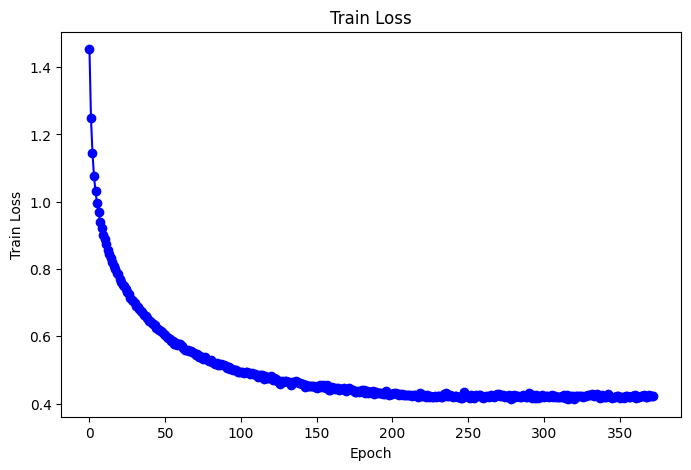

In [27]:
import matplotlib.pyplot as plt

train_loss = [a[0] for a in train_losses]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, marker='o', linestyle='-', color='b', label='Train loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Jaccard')

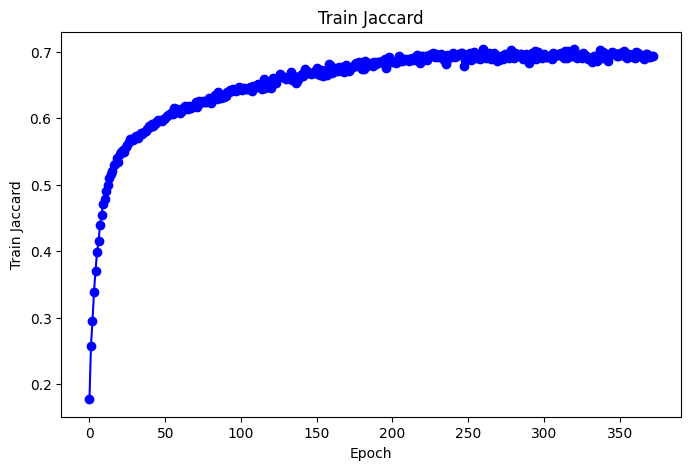

In [28]:
import matplotlib.pyplot as plt

train_Jaccard = [a[1] for a in train_losses]

plt.figure(figsize=(8, 5))
plt.plot(train_Jaccard, marker='o', linestyle='-', color='b', label='Train Jaccard')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Train Jaccard')
plt.title('Train Jaccard')

Text(0.5, 1.0, 'Train F1')

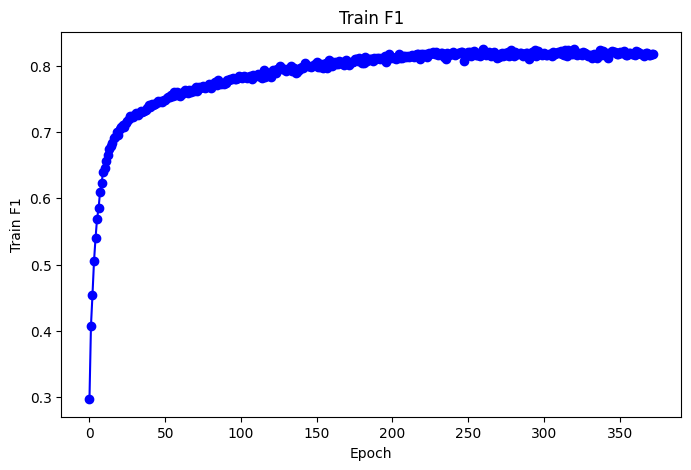

In [29]:
import matplotlib.pyplot as plt

train_F1 = [a[2] for a in train_losses]

plt.figure(figsize=(8, 5))
plt.plot(train_F1, marker='o', linestyle='-', color='b', label='Train F1')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Train F1')
plt.title('Train F1')

Text(0.5, 1.0, 'Train Recall')

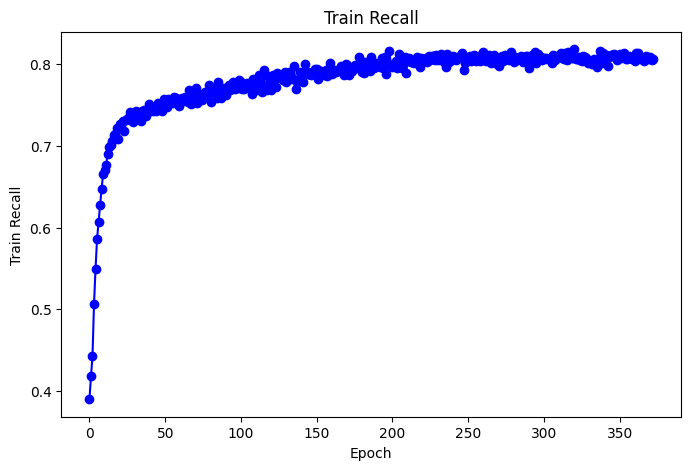

In [30]:
import matplotlib.pyplot as plt

train_Recall = [a[3] for a in train_losses]

plt.figure(figsize=(8, 5))
plt.plot(train_Recall, marker='o', linestyle='-', color='b', label='Train Recall')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Train Recall')
plt.title('Train Recall')

In [33]:
import shutil
shutil.make_archive("results", 'zip', "/kaggle/working/results")

'/kaggle/working/results.zip'